In [4]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# --- 1. Konfiguration ---
INPUT_NPZ_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/top_1000_transcripts.npz'
window_size = 5
lag_offset = 15
USE_HYBRID_MIXING = True # NEU: Schalter für die Normalisierungsmethode
N_ITER = 20

# --- 2. Hilfsfunktionen ---
def create_lagging_windows(read_counts, window_size, lag_offset, constant_values=1):
    padded_counts = np.pad(read_counts, (lag_offset, 0), 'constant', constant_values=constant_values)
    num_windows = len(read_counts)
    shape = (num_windows, window_size)
    strides = (padded_counts.strides[0], padded_counts.strides[0])
    windows = np.lib.stride_tricks.as_strided(padded_counts, shape=shape, strides=strides)
    return windows

def load_processed_data(file_path):
    print(f"Lade verarbeitete Daten von {file_path}...")
    if not os.path.exists(file_path):
        print(f"❌ Fehler: Datendatei nicht gefunden: {file_path}")
        return None
    try:
        data_loader = np.load(file_path, allow_pickle=True)
        transcript_data = {key: data_loader[key] for key in data_loader.files}
        print(f"✅ {len(transcript_data)} Transkripte erfolgreich geladen.")
        return transcript_data
    except Exception as e:
        print(f"❌ Fehler beim Laden der .npz-Datei: {e}")
        return None

# --- 3. Daten laden und für HMM vorbereiten ---
transcript_data = load_processed_data(INPUT_NPZ_FILE)
if not transcript_data:
    exit()

print(f"Bereite Trainingsdaten für das HMM vor ({window_size}-nt Lagging Window)...")
all_X_windows = []
lengths_of_windows = []

for tid, read_counts in tqdm(transcript_data.items(), desc="Verarbeite Transkripte"):
    if len(read_counts) == 0:
        continue

    # Additive Glättung (Pseudocount von 1)
    read_counts = read_counts + 1

    # Der Rest bleibt gleich
    X_single_transcript = create_lagging_windows(read_counts, window_size, lag_offset, constant_values=1)
    all_X_windows.append(X_single_transcript.astype(np.int32)) # Funktioniert jetzt wie erwartet
    lengths_of_windows.append(len(X_single_transcript))


X_train = np.concatenate(all_X_windows)
print(f"✅ Trainings-Set erstellt mit {X_train.shape[0]} Fenstern der Größe {X_train.shape[1]} aus {len(lengths_of_windows)} Transkripten.")

Lade verarbeitete Daten von /home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/top_1000_transcripts.npz...
✅ 1000 Transkripte erfolgreich geladen.
Bereite Trainingsdaten für das HMM vor (5-nt Lagging Window)...


Verarbeite Transkripte: 100%|██████████| 1000/1000 [00:00<00:00, 24281.02it/s]

✅ Trainings-Set erstellt mit 3977752 Fenstern der Größe 5 aus 1000 Transkripten.


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Visualisierung der Initial-Parameter (gruppiert)...


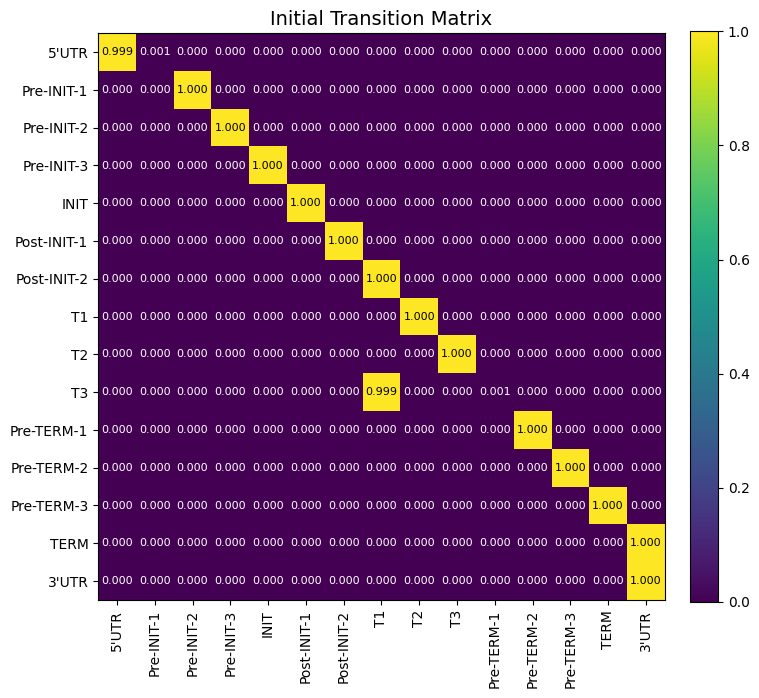

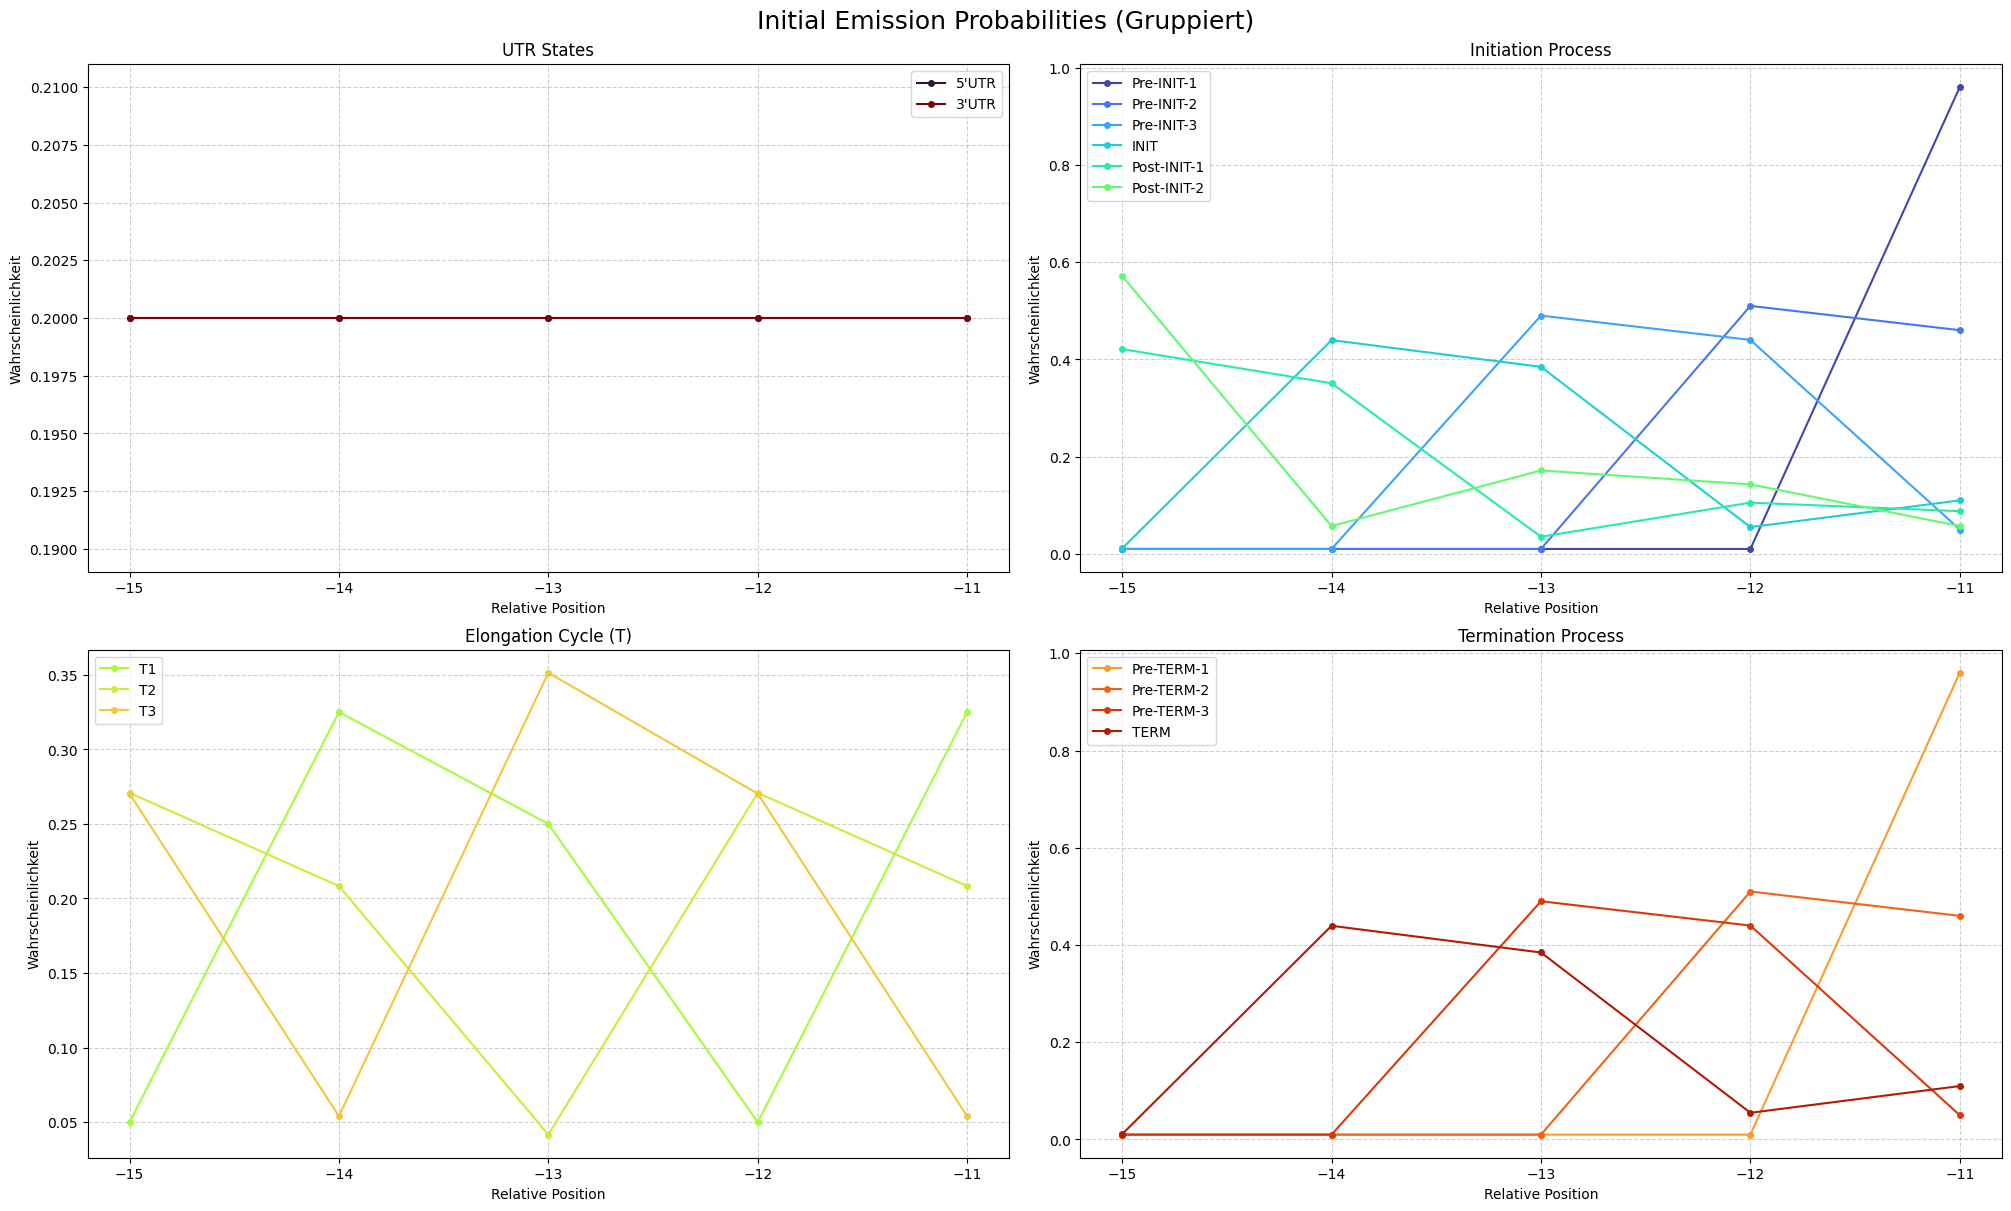

In [ ]:
# --- 1. Modelldefinitionen ---
state_map = {
    "5'UTR": 0, 'Pre-INIT-1': 1, 'Pre-INIT-2': 2, 'Pre-INIT-3': 3, 'INIT': 4,
    'Post-INIT-1': 5, 'Post-INIT-2': 6, 'T1': 7, 'T2': 8, 'T3': 9,
    'Pre-TERM-1': 10, 'Pre-TERM-2': 11, 'Pre-TERM-3': 12, 'TERM': 13, "3'UTR": 14
}
n_components = len(state_map)
n_features = window_size
state_labels = list(state_map.keys())
state_colors = plt.cm.turbo(np.linspace(0, 1, n_components))
# fixed_emission_states = [state_map["5'UTR"], state_map["3'UTR"]]
fixed_emission_states = []
USE_HYBRID_MIXING = False

# --- 2. Emissions-Signaturen definieren ---
emission_blueprints = {
    "5'UTR":        [1, 1, 1, 1, 1],
    'Pre-INIT-1':   [1, 1, 1, 1, 96], 'Pre-INIT-2':   [1, 1, 1, 51, 46],
    'Pre-INIT-3':   [1, 1, 49, 44, 5], 'INIT':         [1, 40, 35, 5, 10],
    'Post-INIT-1':  [60, 50, 5, 15, 12.5], 'Post-INIT-2':  [50, 5, 15, 12.5, 5],
    'T1':           [5, 32.5, 25, 5, 32.5], 'T2':           [32.5, 25, 5, 32.5, 25],
    'T3':           [25, 5, 32.5, 25, 5],
    'Pre-TERM-1':   [1, 1, 1, 1, 96], 'Pre-TERM-2':   [1, 1, 1, 51, 46],
    'Pre-TERM-3':   [1, 1, 49, 44, 5], 'TERM':         [1, 40, 35, 5, 10],
    "3'UTR":        [1, 1, 1, 1, 1]
}

# --- 3. Normalisierungsfunktion ---
def normalize_emissions(unnormalized_emissions, use_hybrid_mixing=False):
    row_sums = unnormalized_emissions.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    shape_component = unnormalized_emissions / row_sums
    if not use_hybrid_mixing: return shape_component
    
    mean_magnitudes = unnormalized_emissions.mean(axis=1)
    learnable_magnitudes = np.delete(mean_magnitudes, fixed_emission_states)
    max_mean_magnitude = learnable_magnitudes.max() if len(learnable_magnitudes) > 0 else 1.0
    if max_mean_magnitude == 0: max_mean_magnitude = 1.0
    
    background_component = np.full_like(unnormalized_emissions, 1.0 / n_features)
    mixing_weights = np.clip((mean_magnitudes / max_mean_magnitude), 0, 1)[:, np.newaxis]
    hybrid_emissions = mixing_weights * shape_component + (1 - mixing_weights) * background_component
    final_sums = hybrid_emissions.sum(axis=1, keepdims=True)
    return hybrid_emissions / np.where(final_sums == 0, 1, final_sums)

# --- 4. HMM-Instanz und Parameter-Initialisierung ---
model = hmm.MultinomialHMM(n_components=n_components,
                           n_iter=N_ITER,
                           tol=1e-3,
                           verbose=True,
                           params='te', 
                           init_params='',
                           random_state=42)

model.startprob_ = np.array([1.0] + [0.0] * (n_components - 1))
transmat = np.zeros((n_components, n_components))
for i in range(n_components - 1):
    if i in [state_map["5'UTR"], state_map["T3"], state_map["TERM"], state_map["3'UTR"]]: continue
    transmat[i, i + 1] = 1.0
transmat[state_map["5'UTR"], state_map["5'UTR"]] = 0.999
transmat[state_map["5'UTR"], state_map["Pre-INIT-1"]] = 0.001
p_elong_cycle = 0.999
transmat[state_map["T3"], state_map["T1"]] = p_elong_cycle
transmat[state_map["T3"], state_map["Pre-TERM-1"]] = 1.0 - p_elong_cycle
transmat[state_map["TERM"], state_map["3'UTR"]] = 1.0
transmat[state_map["3'UTR"], state_map["3'UTR"]] = 1.0
model.transmat_ = transmat

unnormalized_emissions = np.array([emission_blueprints[label] for label in state_labels])
initial_emissionprob = normalize_emissions(unnormalized_emissions, use_hybrid_mixing=USE_HYBRID_MIXING)
model.emissionprob_ = initial_emissionprob.copy()
initial_emissionprob_snapshot = initial_emissionprob.copy()

# --- 5. Visualisierung der Initial-Parameter (JETZT GRUPPIERT) ---
print("Visualisierung der Initial-Parameter (gruppiert)...")

# Definition der Gruppen für die Plots
plot_groups = {
    "UTR States": ["5'UTR", "3'UTR"],
    "Initiation Process": ['Pre-INIT-1', 'Pre-INIT-2', 'Pre-INIT-3', 'INIT', 'Post-INIT-1', 'Post-INIT-2'],
    "Elongation Cycle (T)": ['T1', 'T2', 'T3'],
    "Termination Process": ['Pre-TERM-1', 'Pre-TERM-2', 'Pre-TERM-3', 'TERM']
}

# Erstelle eine Abbildung für die Übergangsmatrix und eine für die Emissionen
fig_transmat = plt.figure(figsize=(8, 8))
ax_transmat = fig_transmat.add_subplot(111)
im = ax_transmat.imshow(model.transmat_, cmap="viridis")
ax_transmat.set_title("Initial Transition Matrix", fontsize=14)
ax_transmat.set_xticks(np.arange(n_components))
ax_transmat.set_yticks(np.arange(n_components))
ax_transmat.set_xticklabels(state_labels, rotation=90)
ax_transmat.set_yticklabels(state_labels)
# Füge die Wahrscheinlichkeitswerte in die Zellen ein
for i in range(n_components):
    for j in range(n_components):
        prob = model.transmat_[i, j]
        text_color = "w" if prob < 0.5 else "k"
        ax_transmat.text(j, i, f"{prob:.3f}",
                       ha="center", va="center", color=text_color, fontsize=8)
plt.colorbar(im, ax=ax_transmat, fraction=0.046, pad=0.04)
plt.show()

# Erstelle eine 2x2-Abbildung für die gruppierten Emissions-Plots
fig_emissions, axs = plt.subplots(2, 2, figsize=(20, 12), constrained_layout=True)
fig_emissions.suptitle("Initial Emission Probabilities (Gruppiert)", fontsize=18)
x_labels_rel = np.arange(n_features) - lag_offset

for ax, (group_name, members) in zip(axs.flat, plot_groups.items()):
    ax.set_title(group_name)
    for state_name in members:
        state_idx = state_map[state_name]
        ax.plot(x_labels_rel, model.emissionprob_[state_idx], 'o-', color=state_colors[state_idx], label=state_name, markersize=4)
    ax.set_xlabel("Relative Position")
    ax.set_ylabel("Wahrscheinlichkeit")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xticks(x_labels_rel)
    ax.legend()

plt.show()

In [14]:
print("Starte Training des MultinomialHMM...")
print(f"Trainingsparameter: params='{model.params}', init_params='{model.init_params}'")
print(f"Anzahl Iterationen: {model.n_iter}, Toleranz: {model.tol}")

model.fit(X_train, lengths=lengths_of_windows)

print("✅ Training abgeschlossen.")

Starte Training des MultinomialHMM...
Trainingsparameter: params='te', init_params=''
Anzahl Iterationen: 20, Toleranz: 0.0001


         1 -15360326.55785886             +nan
         2 -15242133.15863535 +118193.39922351
         3 -15178353.90691730  +63779.25171805
         4 -15161047.71284341  +17306.19407389
         5 -15153203.13560911   +7844.57723430
         6 -15149895.22700449   +3307.90860462
         7 -15148710.33643035   +1184.89057414
         8 -15148468.32586481    +242.01056553
         9 -15148385.15837117     +83.16749365
        10 -15148370.79071219     +14.36765898
        11 -15148369.40755017      +1.38316202
        12 -15148369.14388672      +0.26366344
        13 -15148369.00040828      +0.14347845
        14 -15148368.67388694      +0.32652133
        15 -15148367.01745084      +1.65643611
        16 -15148364.94889871      +2.06855212
        17 -15148364.67379548      +0.27510324
        18 -15148364.64164657      +0.03214891
        19 -15148364.63716161      +0.00448495


✅ Training abgeschlossen.


        20 -15148364.63627278      +0.00088883


In [15]:
import joblib

# Define the filename for saving the model
model_filename = '/home/kai/Documents/00_RNA/00_riboHMM_simple/03_models/hmm_model_et.joblib'

# Save the trained model using joblib.dump
joblib.dump(model, model_filename) # Serialize the model and save it to the file.

print(f"Model saved successfully to {model_filename}")

print(f"Setze Emissionen für fixierte Zustände zurück: {[state_labels[i] for i in fixed_emission_states]}")
for state_idx in fixed_emission_states:
    model.emissionprob_[state_idx] = initial_emissionprob_snapshot[state_idx]
print("Reset abgeschlossen.")

Model saved successfully to /home/kai/Documents/00_RNA/00_riboHMM_simple/03_models/hmm_model_et.joblib
Setze Emissionen für fixierte Zustände zurück: []
Reset abgeschlossen.


✅ ORF-Koordinaten aus '/home/kai/Documents/00_RNA/00_riboHMM_simple/02_Reference_Files/MANE_CDS_coordinates.csv' geladen.
Insgesamt 18525 Transkripte mit ORF-Annotationen gefunden.

Führe Inferenz für ein Beispiel-Transkript durch...
Log-Wahrscheinlichkeit des dekodierten Pfades für ENST00000378609.9: -2741.87
Annotierter ORF für ENST00000378609.9: Start=363, Ende=1386
✅ Pfad-Visualisierung (mit verschobenen Reads und ORF) gespeichert.


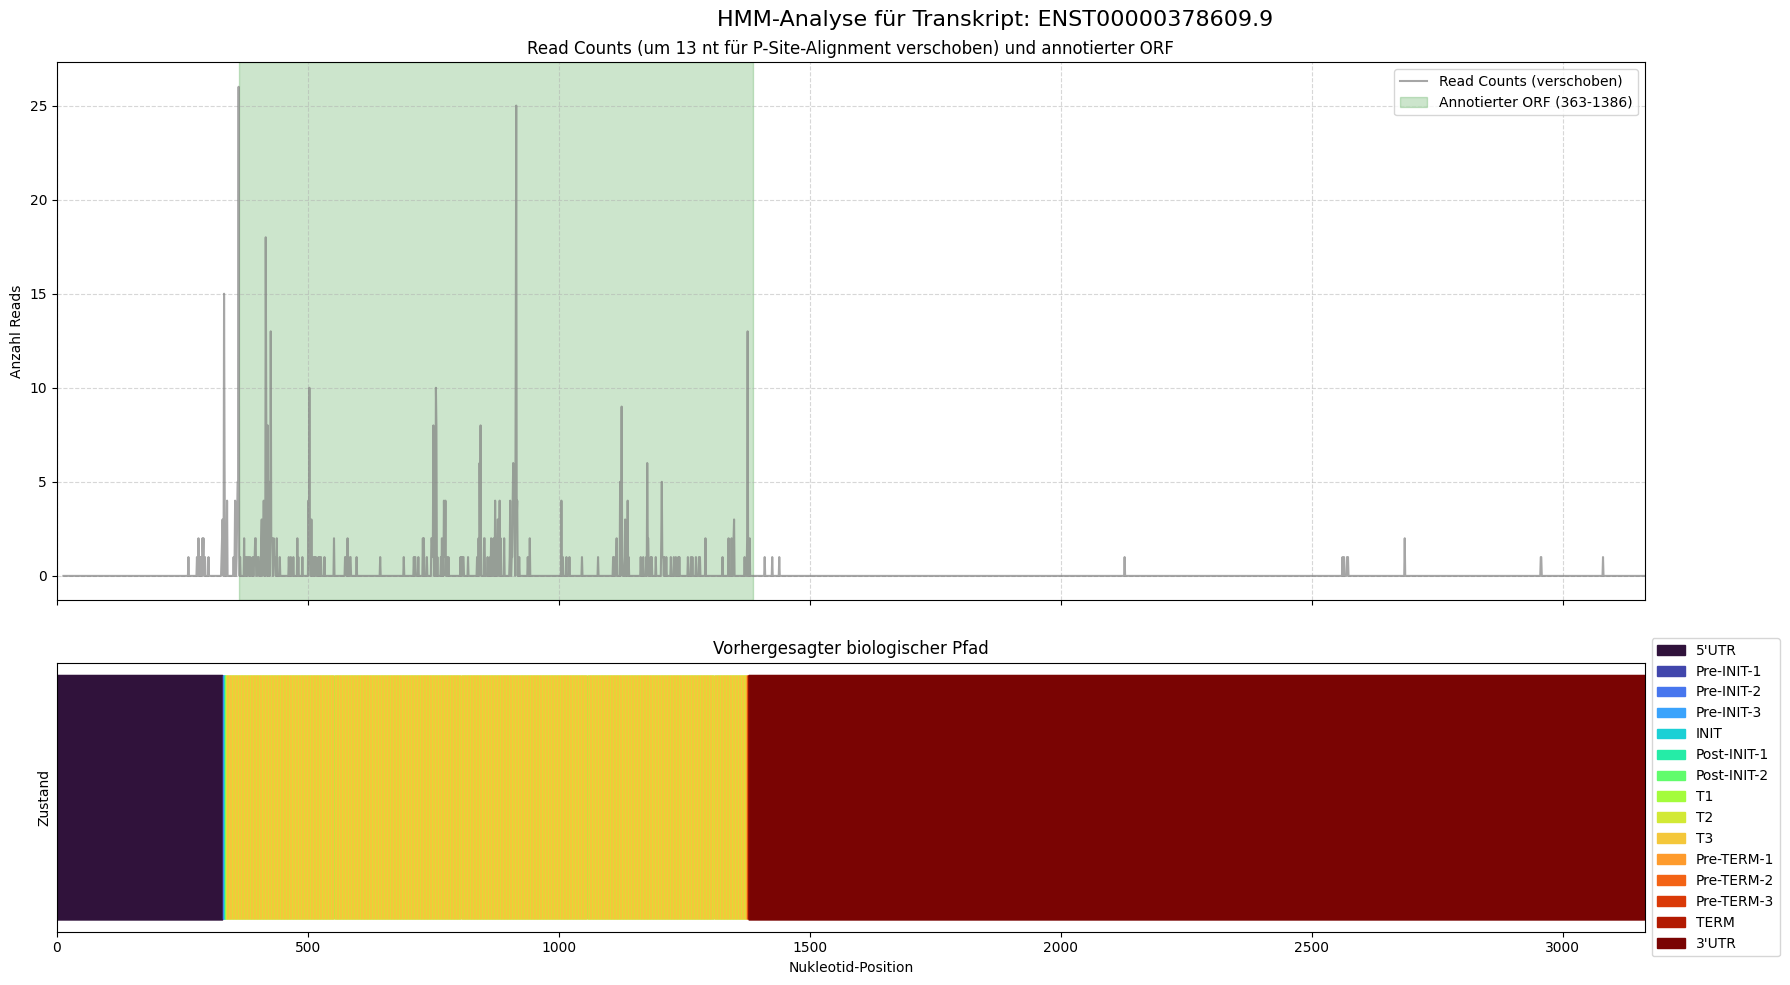


Erstelle Heatmap der gelernten Übergangsmatrix...
✅ Heatmap der Übergangsmatrix gespeichert.


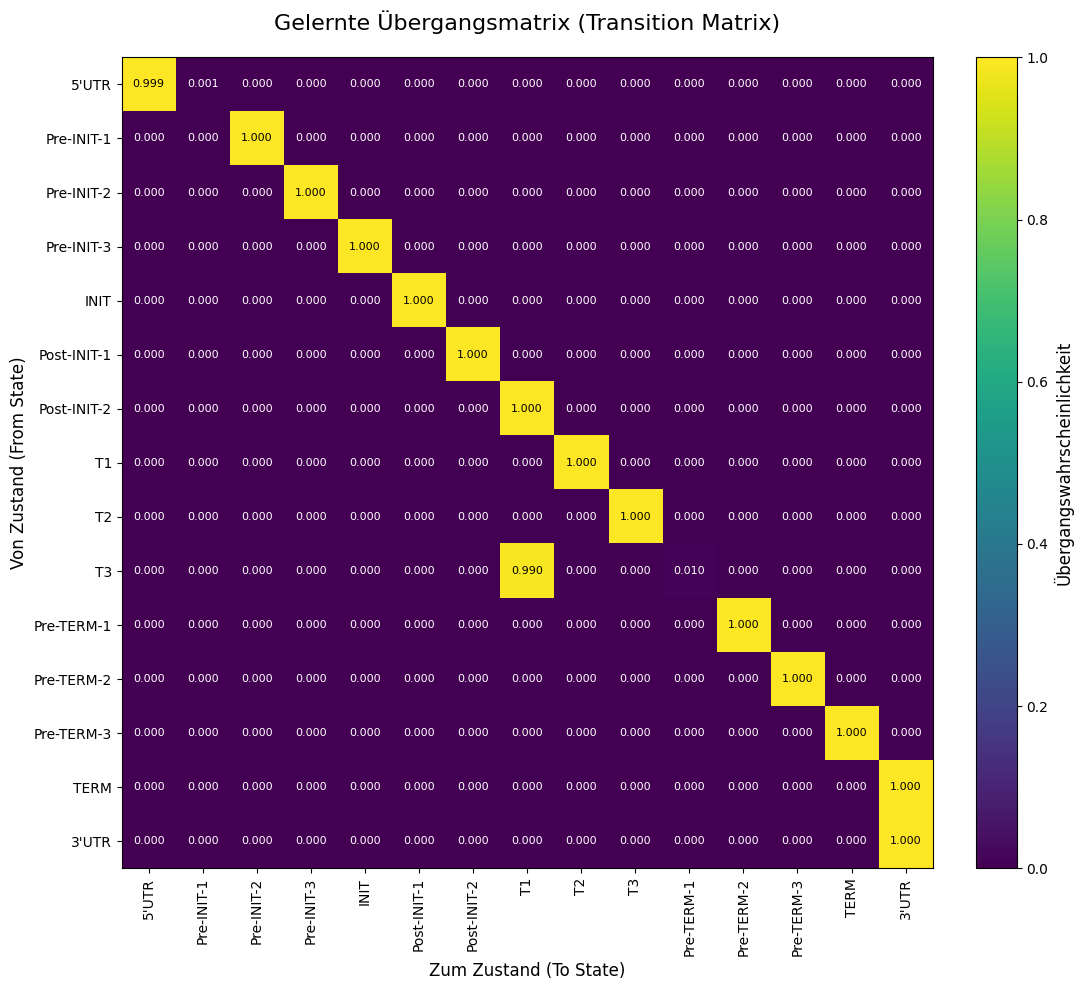


Beginne mit der systematischen Analyse der Start-Codon-Findung...

--- Analyse-Ergebnisse ---
Analyse für 1000 Transkripte mit vorhergesagtem Start durchgeführt.
Genauigkeit der Frame-Findung: 95.60%
✅ Boxplot der Start-Codon-Distanzen gespeichert.


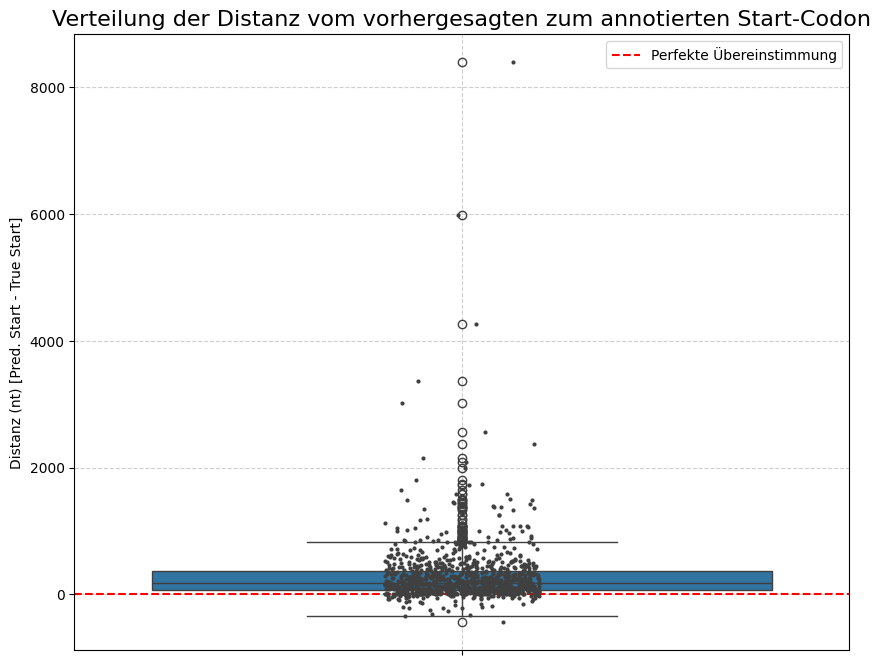

✅ Emissions-Vergleich gespeichert als 'hmm_emissions_comparison_15states_grouped.png'


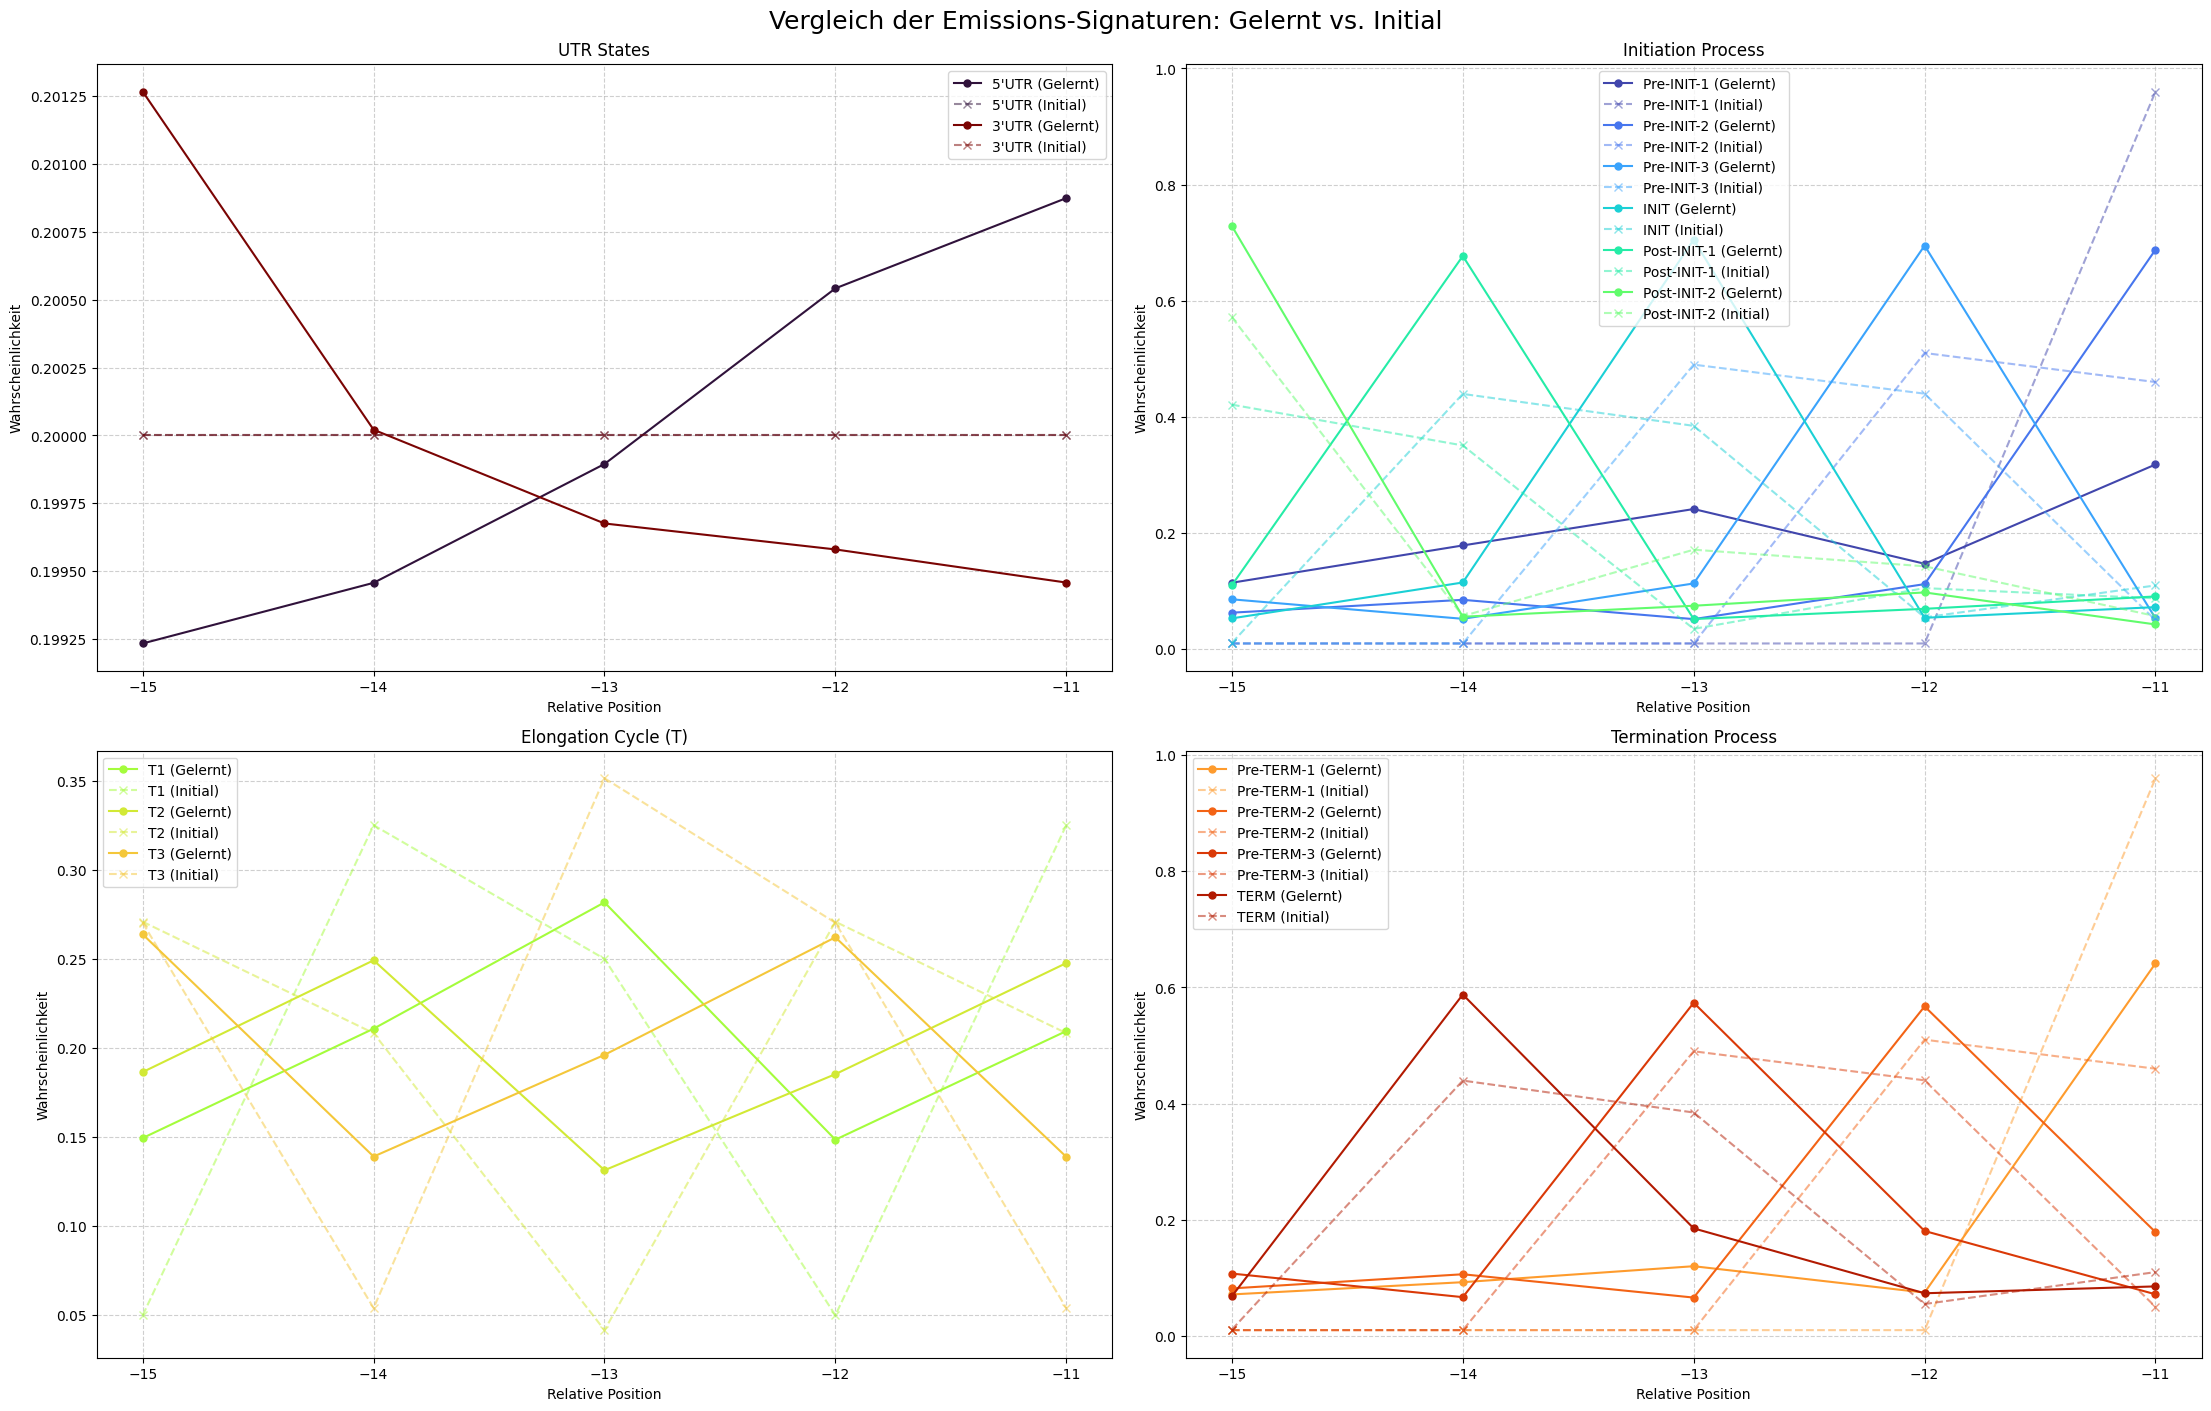

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. Lade die ORF-Koordinaten aus der CSV-Datei ---
try:
    orf_coordinates_path = '/home/kai/Documents/00_RNA/00_riboHMM_simple/02_Reference_Files/MANE_CDS_coordinates.csv'
    orf_df = pd.read_csv(orf_coordinates_path)
    # Setze die Transkript-ID als Index für schnellen Zugriff
    orf_df.set_index('Transcript stable ID version', inplace=True)
    print(f"✅ ORF-Koordinaten aus '{orf_coordinates_path}' geladen.")
    print(f"Insgesamt {len(orf_df)} Transkripte mit ORF-Annotationen gefunden.")
except FileNotFoundError:
    print(f"⚠️ ACHTUNG: Konnte die ORF-Datei nicht finden unter: {orf_coordinates_path}. Überspringe ORF-Analyse.")
    orf_df = None


# --- 1. Inferenz für ein Beispiel-Transkript ---
print("\nFühre Inferenz für ein Beispiel-Transkript durch...")
# Annahme: 'transcript_data' ist ein dict, das aus einem vorherigen Schritt geladen wurde
example_tid = list(transcript_data.keys())[0]
example_read_counts = transcript_data[example_tid]
# Annahme: 'create_lagging_windows', 'window_size', 'lag_offset' sind definiert
X_example = create_lagging_windows(example_read_counts, window_size, lag_offset).astype(np.int32)
# Annahme: 'model' ist das trainierte HMM-Objekt
logprob, state_sequence = model.decode(X_example, algorithm="viterbi")
print(f"Log-Wahrscheinlichkeit des dekodierten Pfades für {example_tid}: {logprob:.2f}")

# --- 2. Visualisierung der Ergebnisse ---

# Plot 1: Reads (verschoben) und dekodierter Pfad mit ORF-Annotation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle(f"HMM-Analyse für Transkript: {example_tid}", fontsize=16)

# P-Site-Shift für Visualisierung
p_site_shift = 13
shifted_counts = np.full_like(example_read_counts, fill_value=np.nan, dtype=np.float64)
end_pos = len(example_read_counts)
if end_pos > p_site_shift:
    shifted_counts[p_site_shift:] = example_read_counts[:end_pos - p_site_shift]

ax1.set_title(f"Read Counts (um {p_site_shift} nt für P-Site-Alignment verschoben) und annotierter ORF")
ax1.plot(shifted_counts, label=f"Read Counts (verschoben)", color='gray', alpha=0.7)
ax1.set_ylabel("Anzahl Reads")
ax1.set_xlim(0, len(example_read_counts))
ax1.grid(True, linestyle='--', alpha=0.5)

# Zeichne den annotierten ORF ein, falls vorhanden
if orf_df is not None and example_tid in orf_df.index:
    orf_info = orf_df.loc[example_tid]
    orf_start = orf_info['cDNA coding start']
    orf_end = orf_info['cDNA coding end']
    ax1.axvspan(orf_start, orf_end, color='green', alpha=0.2, label=f'Annotierter ORF ({orf_start}-{orf_end})')
    print(f"Annotierter ORF für {example_tid}: Start={orf_start}, Ende={orf_end}")

ax1.legend(loc='upper right')
# Annahme: 'state_labels', 'state_colors' sind definiert
ax2.set_title("Vorhergesagter biologischer Pfad")
for i, label in enumerate(state_labels):
    ax2.fill_between(np.arange(len(state_sequence)), 0, 1, where=(state_sequence == i), color=state_colors[i], label=label, step='post')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_ylabel("Zustand")
ax2.set_xlabel("Nukleotid-Position")
ax2.set_yticks([])
ax2.set_xlim(0, len(state_sequence))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("hmm_path_visualization_shifted_with_orf.png")
print("✅ Pfad-Visualisierung (mit verschobenen Reads und ORF) gespeichert.")
plt.show()


# --- 3. Visualisierung der gelernten Übergangsmatrix als Heatmap ---
print("\nErstelle Heatmap der gelernten Übergangsmatrix...")

# Die gelernte Übergangsmatrix aus dem Modell extrahieren
learned_transmat = model.transmat_
# Annahme: 'n_components' ist definiert
n_components = model.n_components

fig_transmat, ax_transmat = plt.subplots(figsize=(12, 10))
im = ax_transmat.imshow(learned_transmat, cmap="viridis", vmin=0, vmax=1)

# Titel und Achsenbeschriftungen
ax_transmat.set_title("Gelernte Übergangsmatrix (Transition Matrix)", fontsize=16, pad=20)
ax_transmat.set_xlabel("Zum Zustand (To State)", fontsize=12)
ax_transmat.set_ylabel("Von Zustand (From State)", fontsize=12)
ax_transmat.set_xticks(np.arange(n_components))
ax_transmat.set_yticks(np.arange(n_components))
ax_transmat.set_xticklabels(state_labels, rotation=90)
ax_transmat.set_yticklabels(state_labels)

# Füge die Wahrscheinlichkeitswerte in die Zellen ein
for i in range(n_components):
    for j in range(n_components):
        prob = learned_transmat[i, j]
        text_color = "w" if prob < 0.5 else "k"
        ax_transmat.text(j, i, f"{prob:.3f}",
                       ha="center", va="center", color=text_color, fontsize=8)

# Füge eine Farbleiste hinzu
cbar = fig_transmat.colorbar(im, ax=ax_transmat, fraction=0.046, pad=0.04)
cbar.set_label('Übergangswahrscheinlichkeit', fontsize=12)

plt.tight_layout()
plt.savefig("hmm_transition_matrix_heatmap.png")
print("✅ Heatmap der Übergangsmatrix gespeichert.")
plt.show()


# --- 4. Analyse der Start-Codon-Findung und Frame-Genauigkeit ---
if orf_df is not None:
    print("\nBeginne mit der systematischen Analyse der Start-Codon-Findung...")
    start_codon_distances = []
    frame_hits = []

    # Annahme: 'state_map' ist definiert
    translating_state_indices = [state_map['T1'], state_map['T2'], state_map['T3']]

    for tid, read_counts in transcript_data.items():
        if tid not in orf_df.index:
            continue

        X = create_lagging_windows(read_counts, window_size, lag_offset).astype(np.int32)
        if X.shape[0] == 0:
            continue
            
        _logprob, sequence = model.decode(X, algorithm="viterbi")
        
        predicted_orf_indices = np.where(np.isin(sequence, translating_state_indices))[0]

        if len(predicted_orf_indices) > 0:
            predicted_start = predicted_orf_indices[0]
            true_start = orf_df.loc[tid, 'cDNA coding start']
            
            distance = predicted_start - true_start
            start_codon_distances.append(distance)
            
            is_frame_hit = (distance % 3 == 0)
            frame_hits.append(is_frame_hit)

    if start_codon_distances:
        frame_accuracy = np.mean(frame_hits) * 100
        print(f"\n--- Analyse-Ergebnisse ---")
        print(f"Analyse für {len(start_codon_distances)} Transkripte mit vorhergesagtem Start durchgeführt.")
        print(f"Genauigkeit der Frame-Findung: {frame_accuracy:.2f}%")

        plt.figure(figsize=(10, 8))
        sns.boxplot(y=start_codon_distances)
        sns.stripplot(y=start_codon_distances, color=".25", size=3)
        plt.title('Verteilung der Distanz vom vorhergesagten zum annotierten Start-Codon', fontsize=16)
        plt.ylabel('Distanz (nt) [Pred. Start - True Start]')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.axhline(0, color='red', linestyle='--', label='Perfekte Übereinstimmung')
        plt.legend()
        plt.savefig("start_codon_distance_boxplot.png")
        print("✅ Boxplot der Start-Codon-Distanzen gespeichert.")
        plt.show()
    else:
        print("⚠️ Keine Translations-Starts gefunden. Boxplot kann nicht erstellt werden.")

# --- 5. Plot: Vergleich der Emissions-Signaturen (unverändert) ---
# Annahme: 'plot_groups', 'n_features', 'initial_emissionprob_snapshot' sind definiert
fig_comparison, axs = plt.subplots(2, 2, figsize=(22, 14), constrained_layout=True)
fig_comparison.suptitle("Vergleich der Emissions-Signaturen: Gelernt vs. Initial", fontsize=18)
x_labels_rel = np.arange(n_features) - lag_offset

for ax, (group_name, members) in zip(axs.flat, plot_groups.items()):
    ax.set_title(group_name)
    for state_name in members:
        state_idx = state_map[state_name]
        ax.plot(x_labels_rel, model.emissionprob_[state_idx], 'o-', color=state_colors[state_idx], label=f'{state_name} (Gelernt)', markersize=5)
        ax.plot(x_labels_rel, initial_emissionprob_snapshot[state_idx], 'x--', color=state_colors[state_idx], alpha=0.5, label=f'{state_name} (Initial)', markersize=6)
    
    ax.set_xlabel("Relative Position")
    ax.set_ylabel("Wahrscheinlichkeit")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xticks(x_labels_rel)
    ax.legend()

plt.savefig("hmm_emissions_comparison_15states_grouped.png")
print("✅ Emissions-Vergleich gespeichert als 'hmm_emissions_comparison_15states_grouped.png'")
plt.show()